<a href="https://colab.research.google.com/github/tamburins/ESAA-2022-/blob/main/ESAA_12_30(452~465).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 06 군집화 실습 - 고객 세그먼테이션

#### 고객 세그먼테이션 정의와 기법

고객을 분류하는 요소로 어떤 상품을 얼마나 많은 비용을 써서 자주 사용하느냐에 기반한 정보로 분류하는 것이 보통이며, 주요 목표는 타겟 마케팅으로 고객을 여러 특성에 맞게 세분화하여 맞춤형 마케팅이나 서비스를 제공하는 것

어떤 요소를 기반을 군집화할 것인지가 중요한데 여기서는 RFM(ReCency, Frequency, Monetary value)를 기반으로 군집화

#### 데이터 세트 로딩과 데이터 클렌징


In [31]:
url = "/content/drive/MyDrive/Colab Notebooks/ESAA/Online Retail.xlsx"

In [32]:
from google.colab import auth
auth.authenticate_user()

In [33]:

import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt

retail_df = pd.read_excel(io="/content/drive/MyDrive/Colab Notebooks/ESAA/Online Retail.xlsx")
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


invoiceNo: 주문번호

StockCode: 제품 코드

Description: 제품 설명

Quanity: 주문 제품 건수

invoiceDate: 주문 일자

UnitPrice: 제품 단가

CustomerID: 고객 번호

Country: 국가명

In [34]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [35]:
#customerid null값이 다수 존재 > 널값인 데이터 삭제
# 오류데이터인 quanity unitprice가 0보다 작은 데이터들을 모두 삭제
reatil_df = retail_df[retail_df['Quantity']>0]
reatil_df = retail_df[retail_df['UnitPrice']>0]
reatil_df = retail_df[retail_df['CustomerID'].notnull()]

print(retail_df.shape)
reatil_df.isnull().sum()

(541909, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [36]:
retail_df['Country'].value_counts()[:5]

United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Name: Country, dtype: int64

In [37]:
retail_df = retail_df[retail_df['Country']=='United Kingdom']
print(retail_df.shape)

(495478, 8)


### RFM 기반 데이터 가공

- 주문 금액 변수 제작, customernoe도 식별성을 위해 int형으로 변경

In [38]:

# 주문 금액 데이터 생성 (UnitPrice*Quantity)
# CustomerNo를 편리한 식별성을 위해 float형을 int형으로 변경
retail_df['sale_amount'] = retail_df['Quantity'] *retail_df['UnitPrice']


<ipython-input-38-7b256b24373d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_df['sale_amount'] = retail_df['Quantity'] *retail_df['UnitPrice']


In [39]:
retail_df.CustomerID.dropna(inplace=True)

In [40]:
retail_df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
Country             0
sale_amount         0
dtype: int64

In [ ]:
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

In [42]:
# Top5 주문 건수와 주문 금액을 가진 고객 데이터 추출
print(retail_df['CustomerID'].value_counts().head(5),'\n')
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

17841.0    7983
14096.0    5128
12748.0    4642
14606.0    2782
15311.0    2491
Name: CustomerID, dtype: int64 



KeyError: ignored

In [43]:
# 특정 고객에 치중된 주문 건수와 주문 금액을 확인
# invoiceno + stockcode로 groupby> 1과 유사한 식별자 레벨
retail_df.groupby(['InvoiceNo', 'StockCode'])['InvoiceNo'].count().mean()


1.0215893791223631

현재의 고객세그멘테이션은 고객 레벨로 주문기간, 주문 횟수, 금액 데이터를 기반으로 하기 때문에 주문번호+상품번호 기반의 데이터를 고객 기준의 frequency, recency, monetary value로 변환하고자 함

데이터 프레임에 그룹바이를 호출해 반환한 데이터 프레임 그룹바이 데이터에 agg를 이용하여 위의 변수를 구하고자 함

In [45]:
# 데이터프레임의 그룹바이의 멀티플연산을 위해 agg() 사용
# recency == invoicedate 컬럼의 max()에서 가공
# frequency 는 invoice 칼럼의 count(), monetary value == sale amount칼럼의 sum()
aggregations={
    'InvoiceDate':'max',
    'InvoiceNo':'count',
    'sale_amount':'sum'
}
cust_df=retail_df.groupby('CustomerID').agg(aggregations)
#groupby된 결과 컬럼 값을 Recency, Frequency, Monetary로 변경
cust_df=cust_df.rename(columns={'InvoiceDate':'Recency',
                                'InvoiceNo':'Frequency',
                                'sale_amount':'Monetary'})
     

cust_df=cust_df.reset_index()
cust_df.head(3)
     

,CustomerID,Recency,Frequency,Monetary
0,12346.0,2011-01-18 10:17:00,2,0.00
1,12747.0,2011-12-07 14:34:00,103,4196.01
2,12748.0,2011-12-09 12:20:00,4642,29072.10


In [46]:
# 오늘 날짜(현재날짜가 아닌 데이터 작성일 기준) 기준의 최근 주문일
import datetime as dt
cust_df['Recency']=dt.datetime(2011, 12,10) - cust_df['Recency']
cust_df['Recency']=cust_df['Recency'].apply(lambda x: x.days+1)
print('cust_df 로우와 칼럼 건수는: ',cust_df.shape)
cust_df.head(3)


cust_df 로우와 칼럼 건수는:  (3950, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.00
1,12747.0,3,103,4196.01
2,12748.0,1,4642,29072.10


#### RFM 기반 고객 세그멘테이션

군집화가 한쪽 군집에 치중되는 현상이 발생하는데 이렇게 왜곡된 분포도의 군집화가 어떻게 진행되는지 알아보고자 함

(array([3.921e+03, 1.500e+01, 1.100e+01, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([ -4287.63 ,  21784.982,  47857.594,  73930.206, 100002.818,
        126075.43 , 152148.042, 178220.654, 204293.266, 230365.878,
        256438.49 ]),
 <a list of 10 Patch objects>)

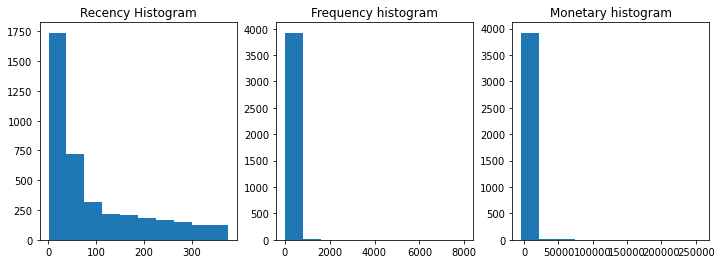

In [47]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary histogram')
ax3.hist(cust_df['Monetary'])


In [48]:
#frequency가 치중되어 있음을 확인
cust_df[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,3950.000000,3950.000000,3950.000000
mean,92.323038,91.614684,1713.385669
std,100.236848,220.557389,6548.608224
min,1.000000,1.000000,-4287.630000
25%,17.000000,17.000000,282.255000
50%,51.000000,41.000000,627.060000
75%,144.000000,101.000000,1521.782500
max,374.000000,7983.000000,256438.490000


In [49]:
# 평균이 91이지만 중위값이 50보다 크게 높으며 max가 75%
# frequency 또한 평균에 비해 75퍼 값이 치중되어 있음을 확인
# 왜곡 정도가 높은 데이터세트에 평균군집을 적용하면 변별력이 떨어지는 군집화가 수행됨
# 이를 개선하기위해 standard scaler로 평균과 표준편차로 재조정하여 k평균을 수행
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features=cust_df[['Recency','Frequency','Monetary']].values
X_features_scaled=StandardScaler().fit_transform(X_features)

kmeans=KMeans(n_clusters=3,random_state=0)
labels=kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label']=labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))


실루엣 스코어는 : 0.585


In [50]:
#visualize silhouette function
# 군집별 실루엣 계수 값 보기

#군집 개수별로 군집화 구성을 시각화하는 함수
def visualize_silhouette(cluster_lists, X_features): 

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    n_cols = len(cluster_lists)

    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    for ind, n_cluster in enumerate(cluster_lists):

        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

  
     

In [51]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화 
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

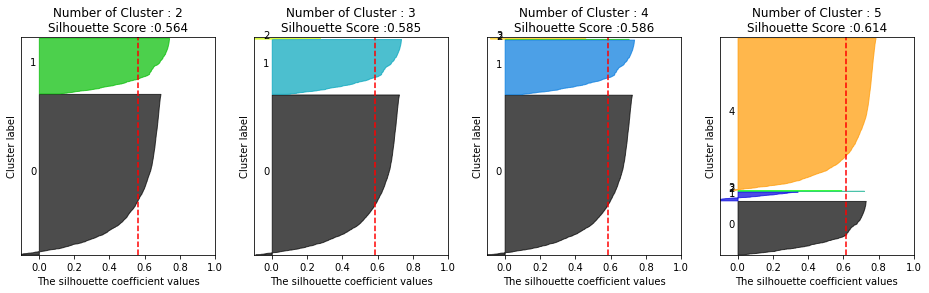

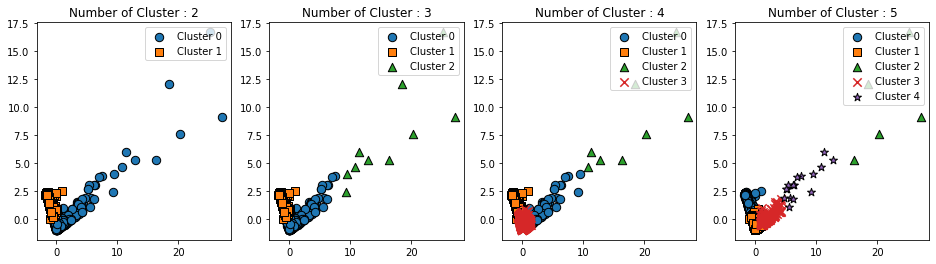

In [52]:
visualize_silhouette([2,3,4,5], X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5], X_features_scaled)


군집이 2개일 경우 너무 개괄적인 군집화, 군집수를 증가시켜도 데이터세트의 개수가 너무 적어 실루엣 계수가 적은 군집이 생성되며, 이러한 소수의 데이터는 특정 소매점의 대량주문 구매로 군집수를 늘려도 이 주문에 대해서만 분류를 진행하여 군집 개수를 늘리는게 무의미함

비지도학습 중 하나인 군집화의 기능적 의미는 숨어있는 새 집단의 발견으로 이 데이터세트의 왜곡정도를 낮추기 위한 방법으로는 로그 변환 방법, 적용해보자!

In [53]:
# 로그 변환 후 k평균 알고리즘 적용

### Log 변환을 통해 데이터 변환
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Recency, Frequecny, Monetary 컬럼에 np.log1p() 로 Log Transformation
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

# Log Transformation 데이터에 StandardScaler 적용
X_features = cust_df[['Recency_log','Frequency_log','Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)


/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [54]:
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))
     

ValueError: ignored

In [ ]:
visualize_silhouette([2,3,4,5], X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5], X_features_scaled)

실루엣 스코어는 로그변환 전에 비해 떨어지지만 군집화가 더 균일하게 되어있음을 확인할 수 있음